This notebook explores the **unusually high churn** pattern exhibited by developers; from the granularity of both files and functions. 

As prerequisites, a table of commits sorted by data such as generated [here](https://colab.research.google.com/drive/1KVCVwkmQUdJb2pS2r8p9Gyi0t7CYzHkV) and a static callgraph (in the form of a graphviz .dot file), generated by analysing a repository's source directory, are assumed. 

We start the exploration from a *file* level.


As [this pluralsight's book on development patterns touches on](https://www.pluralsight.com/content/dam/pluralsight2/landing-pages/offers/flow/pdf/Pluralsight_20Patterns_ebook.pdf). To recognize unusual churn levels, a team leader needs to be familiar with "normal churn levels" exhibitted by each individual in their team, spotting periods of struggle, and acting accordingly. 

One way to do this, is with a visual that contrasts between productive throughput and code churn. 

We start with this, but make a couple of admittedly simplistic assumptions: 


*   Productive throughput, from one commit to another, is assumed to be the number of additions made---as extracted from the commits's diff.
*   Code churn is assumed to be the number of deletions.



With those assumptions, we proceed to generate the visual as follows:

In [54]:
google_colab = False
data_path = '../data'
if 'google.colab' in str(get_ipython()):
    google_colab = True
    from google.colab import drive  
    drive.mount('/content/drive')
    !git clone https://github.com/HPCL/ideas-uo.git
    !ls ideas-uo/data/high_churn_data/

In [2]:
import pandas as pd 
import os
lammps_sorted_commits = pd.read_csv(os.path.join(data_path,'/high_churn_data/lammps_sorted_commits.csv')).drop(columns=['Unnamed: 0'])

In [3]:
lammps_sorted_commits.head()

year  month  day  doy        dow                  full_date  \
0  2006      9   21  264   Thursday  2006-09-21 16:22:34+00:00   
1  2006      9   26  269    Tuesday  2006-09-26 15:44:28+00:00   
2  2006      9   26  269    Tuesday  2006-09-26 15:43:58+00:00   
3  2006      9   26  269    Tuesday  2006-09-26 15:30:56+00:00   
4  2006      9   27  270  Wednesday  2006-09-27 19:51:49+00:00   

                                               files  \
0  ['a/doc/2001/README.html b/doc/2001/README.htm...   
1  ['a/doc/Section_errors.html b/doc/Section_erro...   
2  ['a/doc/Section_errors.txt b/doc/Section_error...   
3            ['a/doc/Manual.html b/doc/Manual.html']   
4  ['a/tools/Makefile b/tools/Makefile', 'a/tools...   

                                          files_dict  \
0  {'a/doc/2001/README.html b/doc/2001/README.htm...   
1  {'a/doc/Section_errors.html b/doc/Section_erro...   
2  {'a/doc/Section_errors.txt b/doc/Section_error...   
3  {'a/doc/Manual.html b/doc/Manual.html': [8, 4,...   
4  {'a/tools/Makefile b/tools/Makefile': [43, 43,...   

                                             message  \
0      git-svn-id: svn://svn.icms.temple.edu/lamm...   
1      git-svn-id: svn://svn.icms.temple.edu/lamm...   
2      git-svn-id: svn://svn.icms.temple.edu/lamm...   
3      git-svn-id: svn://svn.icms.temple.edu/lamm...   
4      git-svn-id: svn://svn.icms.temple.edu/lamm...   

                                              person    locc   locc+  locc-  \
0  b'sjplimp <sjplimp@f3b2605a-c512-4ea7-a41b-209...   49081   49081      0   
1  b'sjplimp <sjplimp@f3b2605a-c512-4ea7-a41b-209...       3       2      1   
2  b'sjplimp <sjplimp@f3b2605a-c512-4ea7-a41b-209...       3       2      1   
3  b'sjplimp <sjplimp@f3b2605a-c512-4ea7-a41b-209...       8       4      4   
4  b'sjplimp <sjplimp@f3b2605a-c512-4ea7-a41b-209...  132239  132239      0   

                                           sha  
0  b'b93436e48b86c3212ea293db8343b74429bc4ac1'  
1  b'd66323cfcc6d6a439c7f237d2738fc1792ce1f2f'  
2  b'2f73f5a9e4de66c1dc7df39a1c63a770a13c669e'  
3  b'58f4781ab3f0fe609e542b6c73b39111efd2ceba'  
4  b'60c7f745b9b71f08394f3807afc52f56f8b46055'

In [4]:
def sorted_people_commits(year=None, month=None, sorted=True):
  """return list of commits per user as panda dataframes (slices of the original) sorted in descending order by rows. Filter out users with no commits

  param  : year and month as time window from which to search 
  
  """
  people_commits = []
  seen = {}
  for i in range(len(lammps_sorted_commits['person'].index)):
    try:
      throw_away = seen[lammps_sorted_commits['person'][i]]
      if throw_away == 1:
        continue 
    except KeyError:
      seen[lammps_sorted_commits['person'][i]] = 1
      comm_p_year  = None  
      comm_p_year_month = pd.DataFrame({'m_dud' : []}) 
      comm_p_month = pd.DataFrame({'m_dud' : []}) 
      if year is None:
        comm_p_year = True 
        if not (month is None): 
          comm_p_month = (lammps_sorted_commits['month'] == month)
      else:
        comm_p_year = (lammps_sorted_commits['year'] == year)
        if not (month is None):    
          comm_p_year_month = (lammps_sorted_commits['year'] == year) & (lammps_sorted_commits['month'] == month)
      commits_by_p = None
      if not (comm_p_year_month.empty):
        commits_by_p = lammps_sorted_commits[comm_p_year_month & (lammps_sorted_commits['person'] == lammps_sorted_commits['person'][i])]
      elif not (comm_p_month.empty): 
        commits_by_p = lammps_sorted_commits[comm_p_month & (lammps_sorted_commits['person'] == lammps_sorted_commits['person'][i])]
      else: 
        commits_by_p = lammps_sorted_commits[comm_p_year & (lammps_sorted_commits['person'] == lammps_sorted_commits['person'][i])]
      people_commits.append(commits_by_p)
  people_commits = list(filter(lambda x: len(x['full_date']) > 0, people_commits))
  if sorted:
    people_commits.sort(key=lambda x: len(x['full_date']), reverse=True)
  return people_commits

In [5]:
people_n1 = len(list(set(list(lammps_sorted_commits['person']))))

In [6]:
import itertools
years = list(set(list(lammps_sorted_commits['year'])))
people = [list(itertools.chain.from_iterable([list(set(list(e['person']))) for e in sorted_people_commits(year=y)])) for y in years]
people_s = set() 
for l in people: 
  people_s = people_s.union(set(l))
people_n2 = len(list(people_s))

In [7]:
# these numbers should be equal
people_n1 == people_n2

True

List all people - choose one to see data about

In [9]:
import seaborn as sb 
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

applications = ["LAMMPS", "PETSc"] # this will later be populated by querying the database

In [10]:
#@title Please select the project, year, number of top contributors, and number of grid columsn. { run: "auto" }

project = 'LAMMPS' #@param ["LAMMPS", "PETSc"]
year = 2020 #@param {type:"integer"}
month = 'Empty' #@param ['Empty', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
#person = 'Name/Email' #@param list(people_s)
num_top_contributors = 5 #@param [1, 2, 3, 4, 5] {type:"raw"}
grid_columns = 3 #@param[2,3,4] {type:"raw"}
month_dict = {'Empty' : None, 'January' : 1, 'February' : 2, 'March' : 3, 'April' : 4, 'May' : 5, 'June' : 6, 'July' : 7, 'August' : 8, 'September' : 9, 'October' : 10, 'November' : 11, 'December' : 12}
month = month_dict[month]

In [11]:
import matplotlib.gridspec as gridspec

In [12]:
def plot_user(project_name, i, axis):
  topi_pd = sorted_people_commits(year=year, month=month)[i] 
  topi_pd.index = pd.to_datetime(topi_pd['full_date'])
  topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
  if month is None: 
    quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
  else: 
    quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='D')).sum() 
  quarter_checkin_i['locc+'] = np.log2(quarter_checkin_i['locc+']).fillna(0)
  quarter_checkin_i['locc-'] = -np.log2(quarter_checkin_i['locc-']).fillna(0)
  quarter_checkin_i['locc+'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', sharey=True, color='r')
  quarter_checkin_i['locc-'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', style='--', sharey=True, color='b')
  axis.set_title(project_name + ' user (' + str(i) +') add vs delete over time')
  handles, labels = axis.get_legend_handles_labels() 
  fig.legend(handles, labels, loc="lower center")
  print("function was called!")
  plt.show()

In [13]:
#@title Default title text
user = 3 #@param [1,2,3,4,5,6,7] {type: "raw"}


/Users/norris/performance/PythonPerformanceAnalysis/tools/taucmdr/installed/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


function was called!


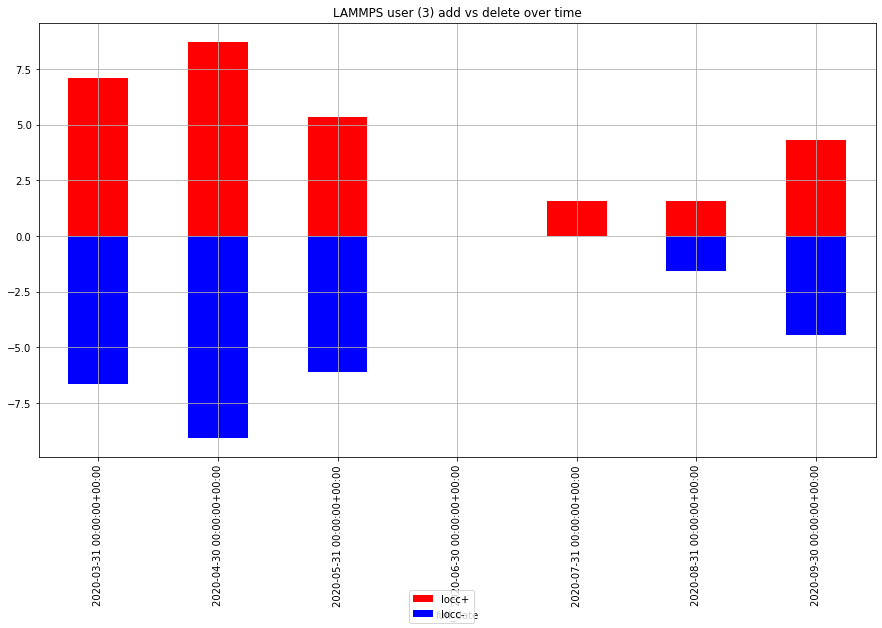

In [14]:
fig, ax = plt.subplots(figsize=(20,8))
plot_user(project, user , ax)

In [15]:
topi_pd = sorted_people_commits(year=year, month=month)[0]
topi_pd.index = pd.to_datetime(topi_pd['full_date'])
topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum()
quarter_checkin_i

year  month   day    doy     locc  locc+    locc-
full_date                                                                     
2020-01-31 00:00:00+00:00  371680    184  3105   3105   213359  21598   191761
2020-02-29 00:00:00+00:00  254520    252  2361   6267     5750   1748     4002
2020-03-31 00:00:00+00:00  321180    477  2227  11767     6899   1849     5050
2020-04-30 00:00:00+00:00  327240    648  2598  17340   319041   1737   317304
2020-05-31 00:00:00+00:00  311080    768  3036  21610    24956  23987      969
2020-06-30 00:00:00+00:00  704980   2094  5712  58760  2042383  24898  2017485
2020-07-31 00:00:00+00:00  579740   2009  3454  55688    38461  31525     6936
2020-08-31 00:00:00+00:00  614080   2431  4762  69483    18591  16773     1818
2020-09-30 00:00:00+00:00  551460   2457  3700  70312    11480   6983     4497
2020-10-31 00:00:00+00:00  539340   2667  3759  76827   126515  65739    60776
2020-11-30 00:00:00+00:00   30300    165    70   4645      142    102       40

In [17]:
def plot_project_month(project_name, y, mo, axis):
  people_srtd = sorted_people_commits(year=y, month=mo)
  top0_pd = people_srtd[0] 
  top0_pd.index = pd.to_datetime(top0_pd['full_date'])
  top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
  daily_checkin_0 = top0_pd.groupby(pd.Grouper(freq='D')).sum()
  daily_checkin_sum =  daily_checkin_0
  for i in range(1, len(people_srtd)):
    topi_pd = sorted_people_commits(year=y, month=mo)[i] 
    topi_pd.index = pd.to_datetime(topi_pd['full_date'])
    topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
    daily_checkin_i = topi_pd.groupby(pd.Grouper(freq='D')).sum() 
    daily_checkin_sum.combine(other=daily_checkin_i, func=(lambda s1, s2 : s1 + s2), fill_value=0)
  daily_checkin_sum['locc+'] = np.log2(daily_checkin_sum['locc+']).fillna(0)
  daily_checkin_sum['locc-'] = -np.log2(daily_checkin_sum['locc-']).fillna(0)
  ax_ans = daily_checkin_sum['locc+'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', sharey=True, color='r')
  ax_ans1 = daily_checkin_sum['locc-'].plot(figsize=(15,8), grid=True, ax=ax_ans, kind='bar', style='--', sharey=True, color='b')
  ax_ans1.set_title(project_name + ' add vs delete in '+ str(mo) + " of" + str(y))
  handles, labels = ax_ans.get_legend_handles_labels() 
  fig.legend(handles, labels, loc="upper right")


In [18]:
def plot_project(project_name, y, axis, mo=None):
  if mo is None: 
    people_srtd = sorted_people_commits(y)
    top0_pd = sorted_people_commits(y)[0] 
    top0_pd.index = pd.to_datetime(top0_pd['full_date'])
    top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
    quarter_checkin_0 = top0_pd.groupby(pd.Grouper(freq='M')).sum()
    quarter_checkin_sum =  quarter_checkin_0
    for i in range(1, len(people_srtd)):
      topi_pd = sorted_people_commits(y)[i] 
      topi_pd.index = pd.to_datetime(topi_pd['full_date'])
      topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
      quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
      quarter_checkin_sum.combine(other=quarter_checkin_i, func=(lambda s1, s2 : s1 + s2), fill_value=0)
    quarter_checkin_sum['locc+'] = np.log2(quarter_checkin_sum['locc+'])
    quarter_checkin_sum['locc-'] = -np.log2(quarter_checkin_sum['locc-'])
    ax_ans = quarter_checkin_sum['locc+'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', sharey=True, color='r')
    ax_ans1 = quarter_checkin_sum['locc-'].plot(figsize=(15,8), grid=True, ax=ax_ans, kind='bar', style='--', sharey=True, color='b')
    ax_ans1.set_title(project_name + ' add vs delete in ' + str(y))
    handles, labels = ax_ans.get_legend_handles_labels() 
    fig.legend(handles, labels, loc="upper right")
    return ax_ans1 
  else: 
    ax_ans2 = plot_project_month(project_name=project_name, y=y, mo=mo, axis=axis)
    return ax_ans2

/Users/norris/performance/PythonPerformanceAnalysis/tools/taucmdr/installed/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


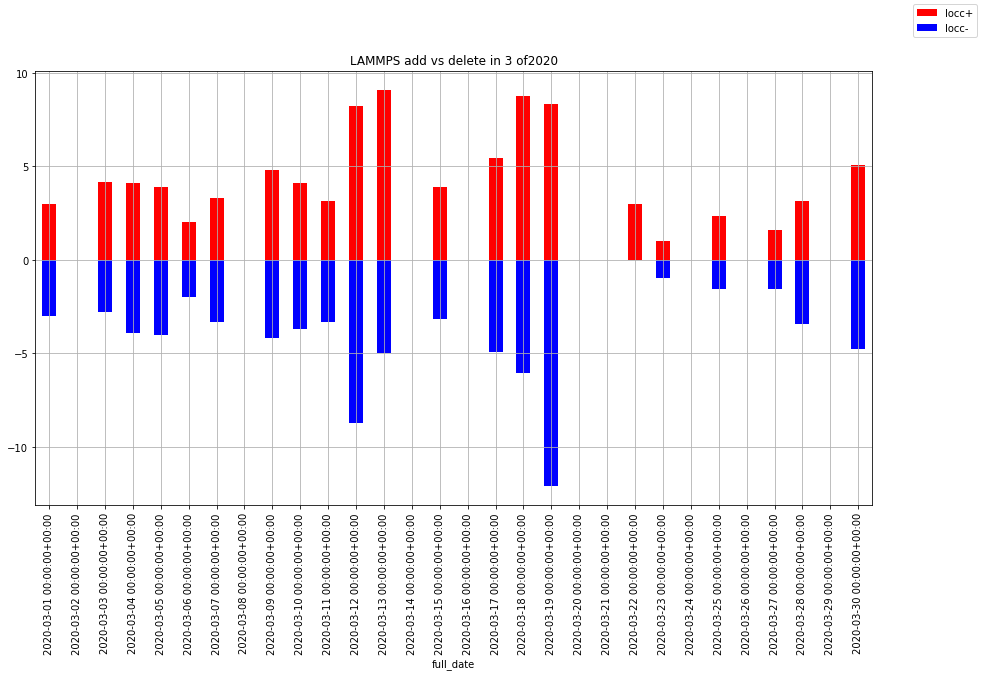

In [19]:
fig, axis = plt.subplots(figsize=(20,8))
plot_project(project_name=project, y=year, mo=3, axis=axis)

<AxesSubplot:title={'center':'LAMMPS add vs delete in 2020'}, xlabel='full_date'>

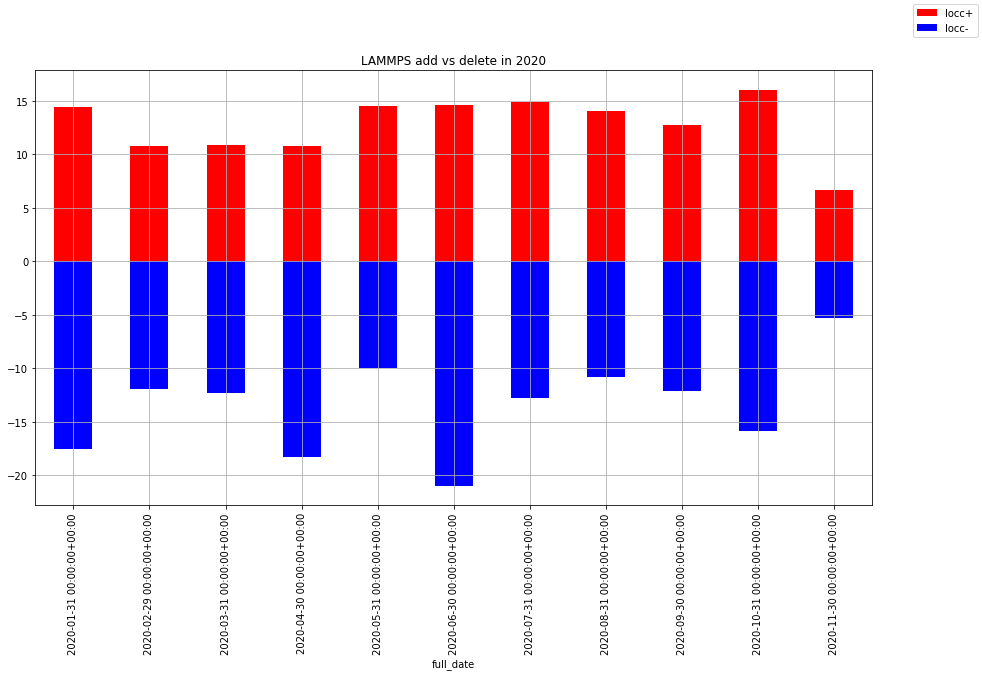

In [20]:
fig, axis = plt.subplots(figsize=(20,8))
plot_project(project, year, axis)

In [21]:
#@title Default title text
year1 = 2016 #@param [2020, 2019, 2018,2017,2016,2015] {type : "raw"} 
year2 = 2017 #@param [2020, 2019, 2018,2017,2016,2015] {type : "raw"}

<AxesSubplot:title={'center':'LAMMPS add vs delete in 2017'}, xlabel='full_date'>

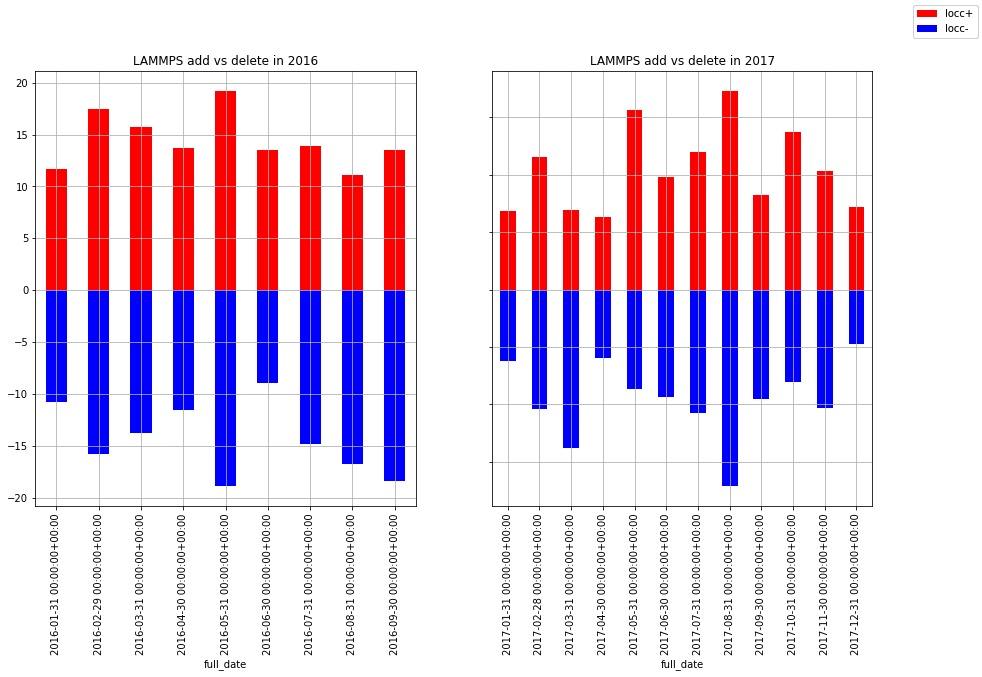

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2) 
plot_project(project, year1, ax1) 
plot_project(project, year2, ax2)

In [23]:
def plot_project_average(project_name, axis):
  year_zero = years[-1]
  people_srtd = sorted_people_commits(year_zero)  # really doesn't matter what year, as all needed is valid year to zero out.
  top0_pd = sorted_people_commits(year_zero)[0] 
  top0_pd.index = pd.to_datetime(top0_pd['full_date'])
  top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
  quarter_checkin_0 = top0_pd.groupby(pd.Grouper(freq='M')).sum()
  all_avgs =  quarter_checkin_0
  num_of_years = len(years)
  for y in years[:-1]:
    people_srtd = sorted_people_commits(y)
    top0_pd = sorted_people_commits(y)[0] 
    top0_pd.index = pd.to_datetime(top0_pd['full_date'])
    top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
    quarter_checkin_0 = top0_pd.groupby(pd.Grouper(freq='M')).sum()
    quarter_checkin_sum =  quarter_checkin_0
    for i in range(1, len(people_srtd)):
      topi_pd = sorted_people_commits(y)[i] 
      topi_pd.index = pd.to_datetime(topi_pd['full_date'])
      topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
      quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
      quarter_checkin_sum.combine(other=quarter_checkin_i, func=(lambda s1, s2 : (s1 + s2)/num_of_years), fill_value=0).fillna(0)
    all_avgs.combine(other=quarter_checkin_sum, func=(lambda s1, s2 : (s1 + s2)), fill_value=0).fillna(0)
  all_avgs['locc+'] = np.log2(all_avgs['locc+'])
  all_avgs['locc-'] = -np.log2(all_avgs['locc-'])
  all_avgs.index = [i.month_name() for i in list(all_avgs.index)]
  ax_ans  = all_avgs['locc+'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', sharey=True, color='r')
  ax_ans1 = all_avgs['locc-'].plot(figsize=(15,8), grid=True, ax=ax_ans, kind='bar', style='--', sharey=True, color='b')
  ax_ans1.set_title(project_name + ' add vs delete in the average year')
  handles, labels = ax_ans1.get_legend_handles_labels() 
  fig.legend(handles, labels, loc="upper right")
  return all_avgs 

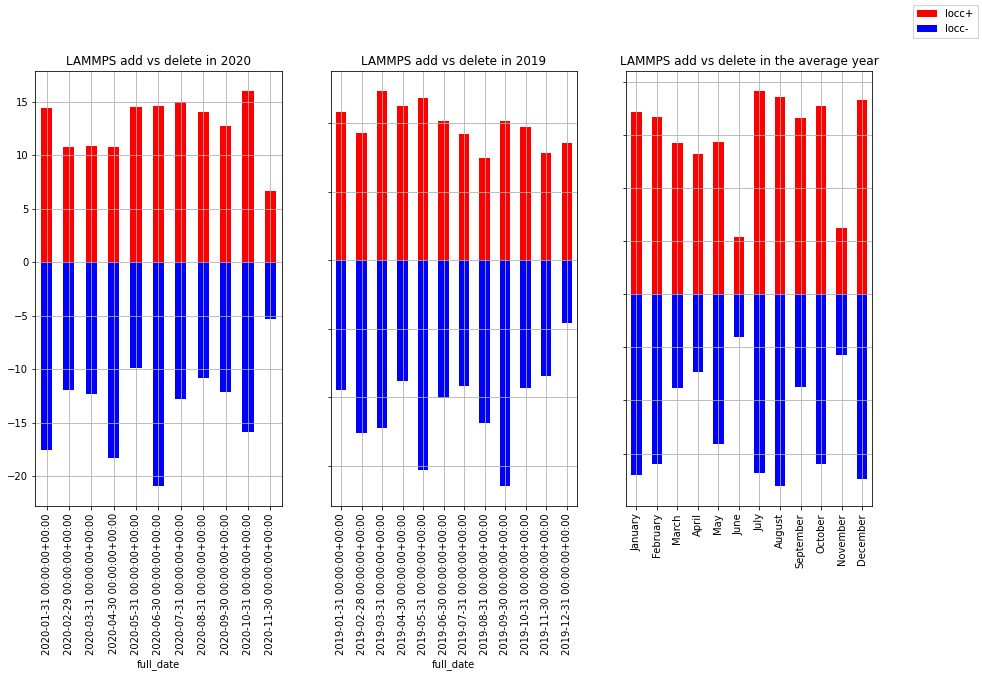

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) 
plot_project(project, year, ax1) 
plot_project(project, 2019, ax2)
all_avgs = plot_project_average(project, ax3)


In [25]:
def plot_project_monthly_avg(project_name, mo, axis):
  year_zero = years[-1]
  people_srtd = sorted_people_commits(year=year_zero, month=mo)  # really doesn't matter what year, as all needed is valid year to zero out.
  top0_pd = people_srtd[0] 
  top0_pd.index = pd.to_datetime(top0_pd['full_date'])
  top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
  quarter_checkin_0 = top0_pd.groupby(pd.Grouper(freq='D')).sum()
  all_avgs =  quarter_checkin_0
  num_of_years = len(years)
  for y in years[:-1]:
    people_srtd = sorted_people_commits(year=y, month=mo)
    print("length of -people_srtd- in year: ", y, len(people_srtd)) 
    if len(people_srtd) > 0:
      top0_pd = people_srtd[0] 
      top0_pd.index = pd.to_datetime(top0_pd['full_date'])
      top0_pd.index = pd.to_datetime(top0_pd.index, utc=True)
      quarter_checkin_0 = top0_pd.groupby(pd.Grouper(freq='D')).sum()
      quarter_checkin_sum =  quarter_checkin_0
      for i in range(1, len(people_srtd)):
        topi_pd = sorted_people_commits(year=y, month=mo)[i] 
        topi_pd.index = pd.to_datetime(topi_pd['full_date'])
        topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
        quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='D')).sum() 
        quarter_checkin_sum.combine(other=quarter_checkin_i, func=(lambda s1, s2 : (s1 + s2)/num_of_years), fill_value=0).fillna(0)
      all_avgs.combine(other=quarter_checkin_sum, func=(lambda s1, s2 : (s1 + s2)), fill_value=0).fillna(0)
  all_avgs['locc+'] = np.log2(all_avgs['locc+']).fillna(0)
  all_avgs['locc-'] = -np.log2(all_avgs['locc-']).fillna(0)
  all_avgs.index = [i.day for i in list(all_avgs.index)]
  ax_ans  = all_avgs['locc+'].plot(figsize=(15,8), grid=True, ax=axis, kind='bar', sharey=True, color='r')
  ax_ans1 = all_avgs['locc-'].plot(figsize=(15,8), grid=True, ax=ax_ans, kind='bar', style='--', sharey=True, color='b')
  ax_ans1.set_title(project_name + ' average add vs delete in month' + str(mo))
  handles, labels = ax_ans1.get_legend_handles_labels() 
  fig.legend(handles, labels, loc="upper right")
  return all_avgs 

length of -people_srtd- in year:  2016 4
length of -people_srtd- in year:  2017 17
length of -people_srtd- in year:  2018 25
length of -people_srtd- in year:  2019 25
length of -people_srtd- in year:  2020 18
length of -people_srtd- in year:  2006 0
length of -people_srtd- in year:  2007 1
length of -people_srtd- in year:  2008 1
length of -people_srtd- in year:  2009 2
length of -people_srtd- in year:  2010 2
length of -people_srtd- in year:  2011 2
length of -people_srtd- in year:  2012 3
length of -people_srtd- in year:  2013 3
length of -people_srtd- in year:  2014 2


/Users/norris/performance/PythonPerformanceAnalysis/tools/taucmdr/installed/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


year  month  day   doy    locc      locc+      locc-
2   24180     84   24  2196     311   7.392317  -7.159871
3       0      0    0     0       0       -inf        inf
4       0      0    0     0       0       -inf        inf
5       0      0    0     0       0       -inf        inf
6   32240    112   96  2992   18920  14.167026  -9.036174
7       0      0    0     0       0       -inf        inf
8   28210     98  112  2646  116997  16.216159 -15.318684
9       0      0    0     0       0       -inf        inf
10      0      0    0     0       0       -inf        inf
11      0      0    0     0       0       -inf        inf
12      0      0    0     0       0       -inf        inf
13   4030     14   26   388      21   3.700440  -3.000000
14  30225    105  210  2925  136336  16.066384 -16.047167
15   6045     21   45   588      31   3.169925  -4.459432
16  44330    154  352  4334    1271  10.055282  -7.693487
17  14105     49  119  1386     114   6.066089  -5.554589
18  12090     42  108  1194      84   5.672425  -5.044394
19      0      0    0     0       0       -inf        inf
20      0      0    0     0       0       -inf        inf
21  18135     63  189  1818     118   6.629357  -4.247928
22  36270    126  396  3654  102500  16.644927  -4.584963
23  12090     42  138  1224    4127  11.014020 -11.007728
24  22165     77  264  2255    6305   7.930737 -12.565340
25      0      0    0     0       0       -inf        inf
26      0      0    0     0       0       -inf        inf
27  30225    105  405  3120   42933  15.387883  -5.832890
28  66495    231  924  6897  241761  17.880504  -8.829723
29   6045     21   87   630      19   4.087463  -1.000000
30  22165     77  330  2321   24081  14.425609 -11.018896
31   6045     21   93   636      95   6.000000  -4.954196

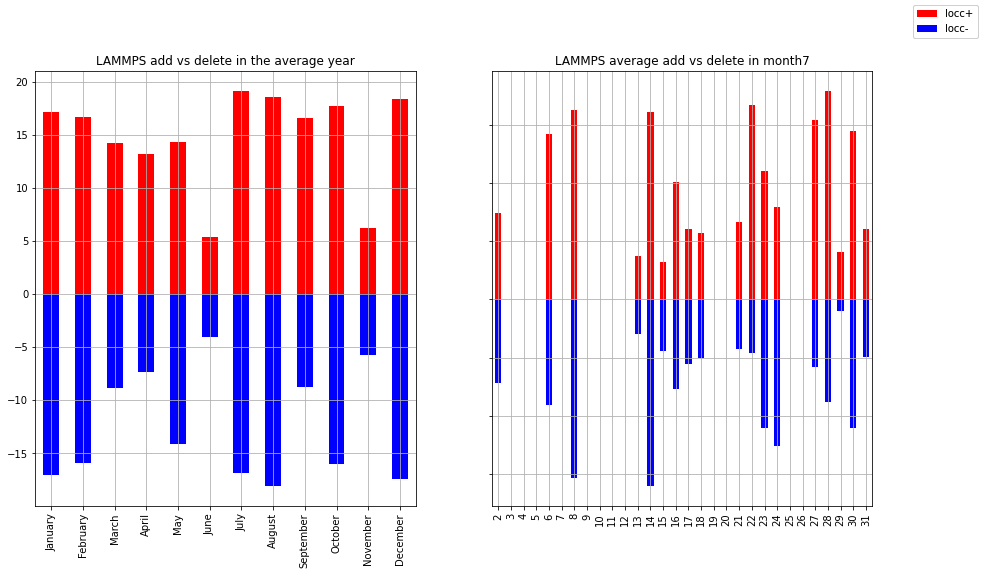

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2) 
plot_project_average(project, ax1)
plot_project_monthly_avg(project_name=project, mo=7, axis=ax2)

Showing just the difference

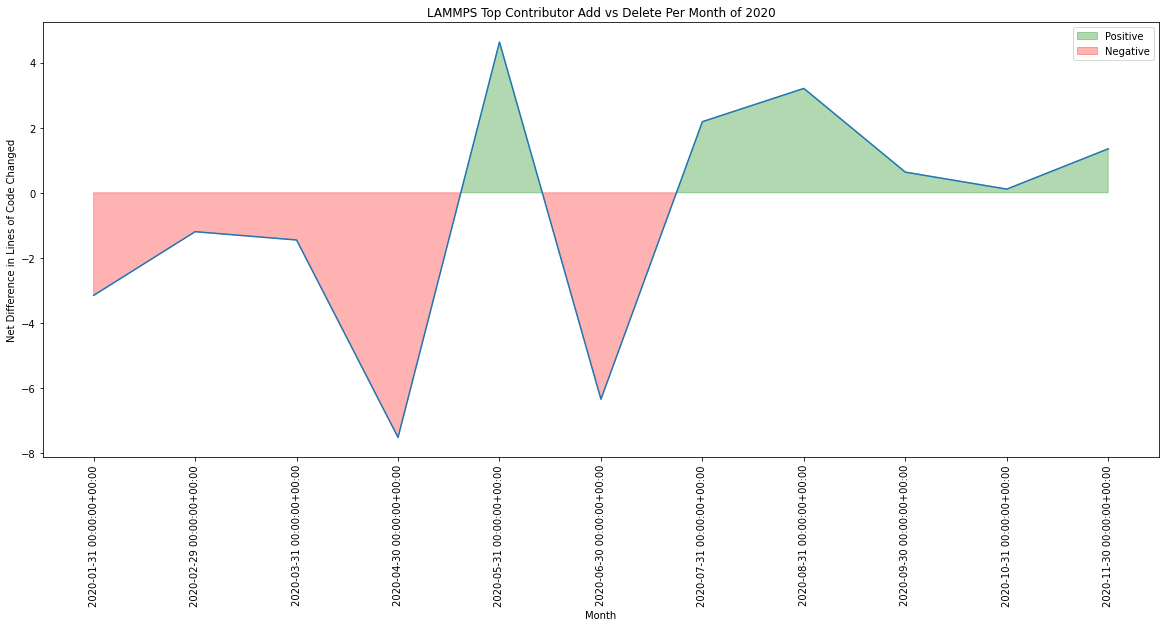

In [27]:
def change_year(year):
  persons = [] 
  for i in range(1):
    topi_pd = sorted_people_commits(year)[i] 
    p       = list(topi_pd['person'])[0] # using zero index for user with most commits. Can vary for different devs
    persons.append(p)
    topi_pd.index = pd.to_datetime(topi_pd['full_date'])
    topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
    quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
    quarter_checkin_i['locc+'] = np.log2(quarter_checkin_i['locc+'])
    quarter_checkin_i['locc-'] = -np.log2(quarter_checkin_i['locc-'])
    y = quarter_checkin_i['locc+'] + quarter_checkin_i['locc-']
  
  
  x = np.arange(len(y))
  fig = plt.figure() 
  fig.set_figwidth(20) 
  fig.set_figheight(8) 
  
  plt.plot(x,y)
  z1 = np.array(y)
  z2 = np.array(0.0 * 10)
  plt.fill_between(x, y, 0,
                  where=(z1 >= z2),
                  alpha=0.30, color='green', interpolate=True, label='Positive')
  plt.fill_between(x, y, 0,
                  where=(z1 < z2),
                  alpha=0.30, color='red', interpolate=True, label='Negative')
  plt.legend()
  plt.xlabel('Month')
  plt.xticks(x, quarter_checkin_i.index, rotation='vertical')
  plt.ylabel("Net Difference in Lines of Code Changed")
  plt.title(project + " Top Contributor Add vs Delete Per Month of " + str(year));
  plt.show();

years.sort(reverse=True)
interact(change_year, year=years);

In [28]:
yearly_commits = lammps_sorted_commits.groupby('year').mean()
yearly_commits['total_locc'] = yearly_commits['locc+']-yearly_commits['locc-']
yearly_commits

month        day         doy         locc        locc+        locc-  \
year                                                                            
2006  10.443396  16.000000  302.820755  6982.792453  6852.301887   130.490566   
2007   6.881703  14.705047  192.807571   641.659306   527.817035   113.842271   
2008   4.896617  15.054511  133.437970   352.810150   115.377820   237.432331   
2009   7.050409  14.489101  197.810627   179.993188   161.212534    18.780654   
2010   7.207781  15.693192  203.739169   366.908046   251.770115   115.137931   
2011   6.345563  15.756826  177.494027  1166.623720   885.783276   280.840444   
2012   6.085456  14.439606  169.170912   607.516845   388.622021   218.894823   
2013   6.017520  16.073450  167.892183  1149.899596   783.710243   366.189353   
2014   5.733477  14.835489  158.109195  1932.579741   981.871408   950.708333   
2015   6.252451  15.873366  174.813725  2385.542484  1633.769608   751.772876   
2016   7.114124  15.809605  201.912994  1796.489266   761.627119  1034.862147   
2017   5.833426  15.509782  161.598099   494.100615   322.250978   171.849637   
2018   7.142475  15.636851  201.610070   672.500268   522.211034   150.289234   
2019   6.468984  15.769468  181.238891   341.400792   239.760669   101.640123   
2020   5.948079  15.319205  165.756821  1886.065695   914.644238   971.421457   

       total_locc  
year               
2006  6721.811321  
2007   413.974763  
2008  -122.054511  
2009   142.431880  
2010   136.632184  
2011   604.942833  
2012   169.727198  
2013   417.520889  
2014    31.163075  
2015   881.996732  
2016  -273.235028  
2017   150.401342  
2018   371.921800  
2019   138.120546  
2020   -56.777219

Text(0, 0.5, 'Total locc')

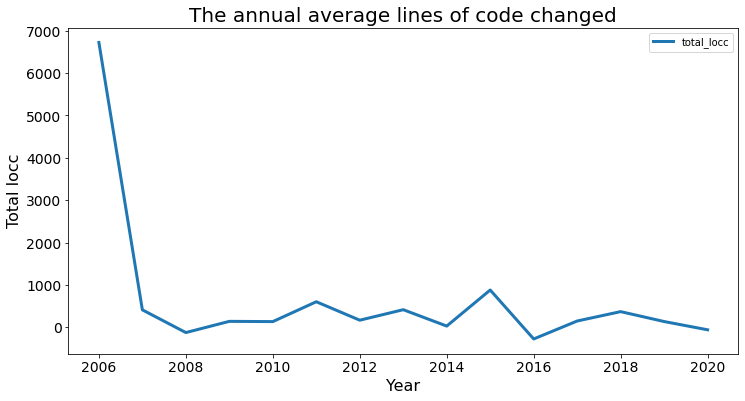

In [29]:
# colors for the line plot
#colors = ['green', 'red', 'purple']

# line plot - the yearly average air temperature in Barcelona
#df_temperature.plot(color=colors, linewidth=3, figsize=(12,6))
yearly_commits.plot( y='total_locc',linewidth=3, figsize=(12,6))


# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(labels =['Average air temperature', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The annual average lines of code changed', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Total locc', fontsize=16)

In [30]:
# the simple moving average over a period of 3 years
yearly_commits['SMA_3'] = yearly_commits.total_locc.rolling(3, min_periods=1).mean()

# the simple moving average over a period of 5 year
yearly_commits['SMA_5'] = yearly_commits.total_locc.rolling(5, min_periods=1).mean()

# the simple moving average over a period of 10 year
yearly_commits['SMA_10'] = yearly_commits.total_locc.rolling(10, min_periods=1).mean()
yearly_commits.head()

month        day         doy         locc        locc+       locc-  \
year                                                                           
2006  10.443396  16.000000  302.820755  6982.792453  6852.301887  130.490566   
2007   6.881703  14.705047  192.807571   641.659306   527.817035  113.842271   
2008   4.896617  15.054511  133.437970   352.810150   115.377820  237.432331   
2009   7.050409  14.489101  197.810627   179.993188   161.212534   18.780654   
2010   7.207781  15.693192  203.739169   366.908046   251.770115  115.137931   

       total_locc        SMA_3        SMA_5       SMA_10  
year                                                      
2006  6721.811321  6721.811321  6721.811321  6721.811321  
2007   413.974763  3567.893042  3567.893042  3567.893042  
2008  -122.054511  2337.910524  2337.910524  2337.910524  
2009   142.431880   144.784044  1789.040863  1789.040863  
2010   136.632184    52.336518  1458.559127  1458.559127

Text(0, 0.5, 'Total locc')

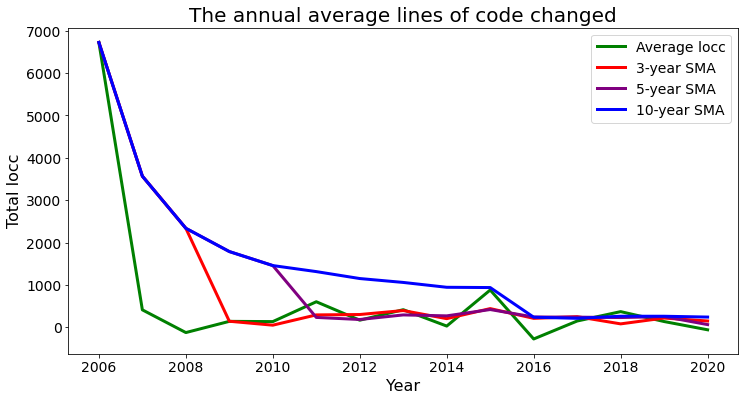

In [31]:
# colors for the line plot
colors = ['green', 'red', 'purple', 'blue']

# line plot 
yearly_commits.plot(y=['total_locc', 'SMA_3', 'SMA_5', 'SMA_10'], color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average locc', '3-year SMA', '5-year SMA', '10-year SMA'], fontsize=14)

# title and labels
plt.title('The annual average lines of code changed', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Total locc', fontsize=16)

In [32]:
lammps_sorted_commits['total_locc'] = lammps_sorted_commits['locc+']-lammps_sorted_commits['locc-']
# Group data first by year, then by month
monthly_commits = lammps_sorted_commits.groupby(["year", "month"]).mean()
monthly_commits=monthly_commits.drop(monthly_commits.index[0])
monthly_commits.head()

day         doy        locc       locc+       locc-  \
year month                                                              
2006 10      9.400000  282.400000  546.450000    3.200000  543.250000   
     11     11.375000  315.375000   35.625000   31.968750    3.656250   
     12     13.217391  347.217391   10.217391    6.521739    3.695652   
2007 1      23.333333   23.333333  738.333333  689.633333   48.700000   
     2      14.886792   45.886792  121.509434   62.886792   58.622642   

            total_locc  
year month              
2006 10    -540.050000  
     11      28.312500  
     12       2.826087  
2007 1      640.933333  
     2        4.264151

In [33]:
# the simple moving average over a period of 3 years
monthly_commits['SMA_3'] = monthly_commits.total_locc.rolling(3, min_periods=1).mean()

# the simple moving average over a period of 5 year
monthly_commits['SMA_6'] = monthly_commits.total_locc.rolling(5, min_periods=1).mean()

# the simple moving average over a period of 10 year
monthly_commits['SMA_12'] = monthly_commits.total_locc.rolling(10, min_periods=1).mean()

monthly_commits.head()

day         doy        locc       locc+       locc-  \
year month                                                              
2006 10      9.400000  282.400000  546.450000    3.200000  543.250000   
     11     11.375000  315.375000   35.625000   31.968750    3.656250   
     12     13.217391  347.217391   10.217391    6.521739    3.695652   
2007 1      23.333333   23.333333  738.333333  689.633333   48.700000   
     2      14.886792   45.886792  121.509434   62.886792   58.622642   

            total_locc       SMA_3       SMA_6      SMA_12  
year month                                                  
2006 10    -540.050000 -540.050000 -540.050000 -540.050000  
     11      28.312500 -255.868750 -255.868750 -255.868750  
     12       2.826087 -169.637138 -169.637138 -169.637138  
2007 1      640.933333  224.023973   33.005480   33.005480  
     2        4.264151  216.007857   27.257214   27.257214

Text(0, 0.5, 'Total locc')

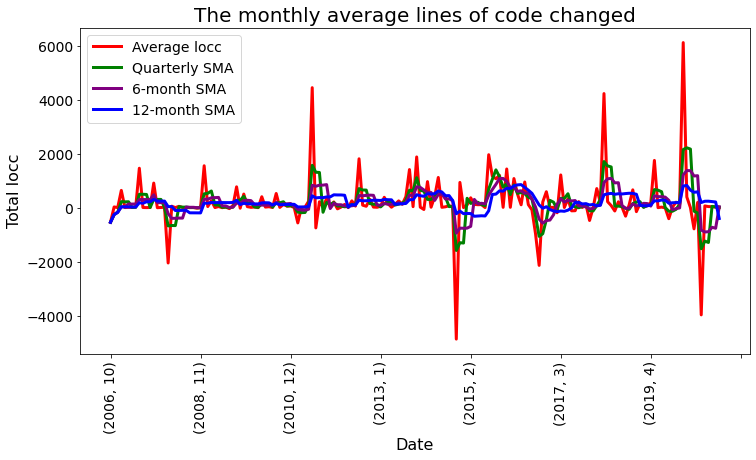

In [34]:
# colors for the line plot
colors = ['red', 'green', 'purple', 'blue']

# line plot 
monthly_commits.plot(y=['total_locc', 'SMA_3', 'SMA_6', 'SMA_12'], color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14, rotation='vertical')
plt.yticks(fontsize=14)
plt.legend(labels =['Average locc', 'Quarterly SMA', '6-month SMA', '12-month SMA'], fontsize=14)

# title and labels
plt.title('The monthly average lines of code changed', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total locc', fontsize=16)

In [35]:
idx = pd.IndexSlice
monthly = monthly_commits.loc[idx[year, :], :]
monthly

day         doy          locc         locc+        locc-  \
year month                                                                   
2020 1      17.481848   17.481848  14024.270627  10071.831683  3952.438944   
     2      19.247664   50.247664    442.084112    419.042056    23.042056   
     3      16.924791   76.924791     44.908078     23.810585    21.097493   
     4      15.384824  106.384824    949.241192     81.815718   867.425474   
     5      18.454545  139.454545    204.720280    199.646853     5.073427   
     6      15.459082  167.459082   4084.267465     55.353293  4028.914172   
     7      12.534442  194.534442    100.717340     82.843230    17.874109   
     8      15.858283  228.858283    214.646707    127.690619    86.956088   
     9      12.647948  256.647948     59.561555     48.963283    10.598272   
     10     13.294479  287.294479    389.736196    202.822086   186.914110   
     11      7.062500  312.062500      6.468750      4.156250     2.312500   

             total_locc        SMA_3        SMA_6      SMA_12  
year month                                                     
2020 1      6119.392739  2155.360134  1215.765795  803.861786  
     2       396.000000  2219.516194  1376.548652  824.140481  
     3         2.713092  2172.701944  1372.958699  649.201301  
     4      -785.609756  -128.965555  1175.130384  570.539930  
     5       194.573427  -196.107746  1185.413900  587.845678  
     6     -3973.560878 -1521.532403  -833.176823  191.294486  
     7        64.969121 -1238.006110  -899.382999  238.582826  
     8        40.734531 -1289.285742  -891.778711  240.589994  
     9        38.365011    48.022888  -726.983758  224.073313  
     10       15.907975    31.669172  -762.716848  211.348526  
     11        1.843750    18.705579    32.364078 -400.406373

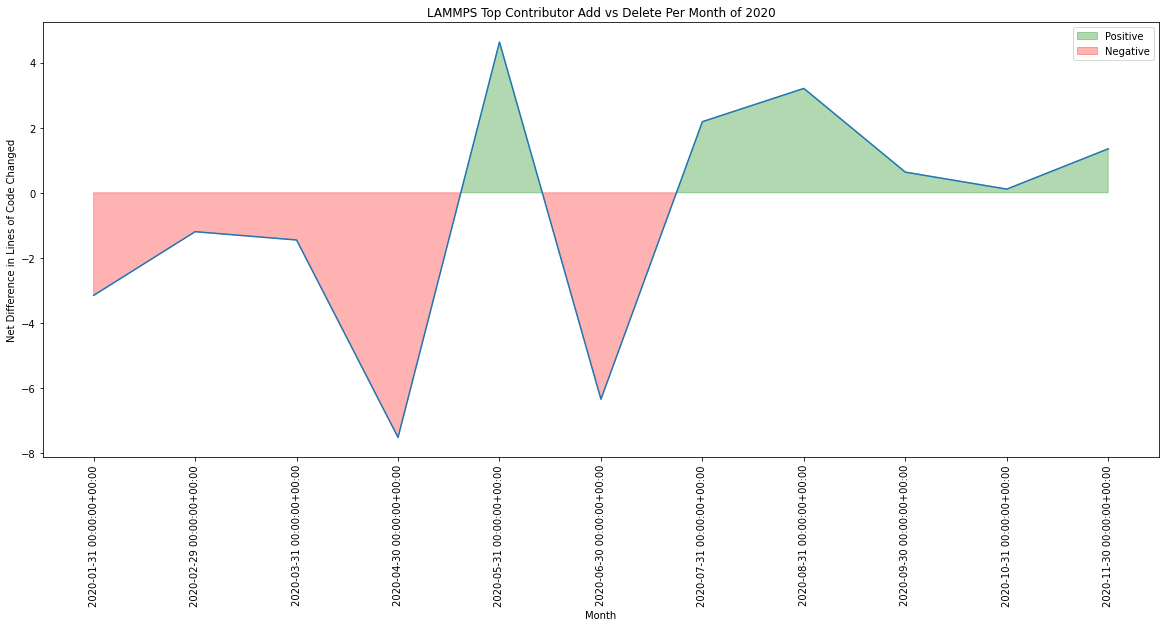

In [36]:
def change_year(year):
  persons = [] 
  for i in range(1):
    topi_pd = sorted_people_commits(year)[i] 
    p       = list(topi_pd['person'])[0] # using zero index for user with most commits. Can vary for different devs
    persons.append(p)
    topi_pd.index = pd.to_datetime(topi_pd['full_date'])
    topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
    quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
    quarter_checkin_i['locc+'] = np.log2(quarter_checkin_i['locc+'])
    quarter_checkin_i['locc-'] = -np.log2(quarter_checkin_i['locc-'])
    y = quarter_checkin_i['locc+'] + quarter_checkin_i['locc-']
  
  
  x = np.arange(len(y))
  fig = plt.figure() 
  fig.set_figwidth(20) 
  fig.set_figheight(8) 
  
  plt.plot(x,y)
  z1 = np.array(y)
  z2 = np.array(0.0 * 10)
  plt.fill_between(x, y, 0,
                  where=(z1 >= z2),
                  alpha=0.30, color='green', interpolate=True, label='Positive')
  plt.fill_between(x, y, 0,
                  where=(z1 < z2),
                  alpha=0.30, color='red', interpolate=True, label='Negative')
  plt.legend()
  plt.xlabel('Month')
  plt.xticks(x, quarter_checkin_i.index, rotation='vertical')
  plt.ylabel("Net Difference in Lines of Code Changed")
  plt.title(project + " Top Contributor Add vs Delete Per Month of " + str(year));
  idx = pd.IndexSlice
  monthly = monthly_commits.loc[idx[year, :], :]
  #plt.plot(x, monthly['total_locc'] )
  plt.show();

years.sort(reverse=True)
interact(change_year, year=years);

In [37]:
import plotly.express as px
persons = [] 
for i in range(1):
  topi_pd = sorted_people_commits(year)[i] 
  p       = list(topi_pd['person'])[0] # using zero index for user with most commits. Can vary for different devs
  persons.append(p)
  topi_pd.index = pd.to_datetime(topi_pd['full_date'])
  topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
  quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='M')).sum() 
  quarter_checkin_i['locc+'] = np.log2(quarter_checkin_i['locc+'])
  quarter_checkin_i['locc-'] = -np.log2(quarter_checkin_i['locc-'])
  quarter_checkin_i['locc total'] = quarter_checkin_i['locc+'] + quarter_checkin_i['locc-']

print(topi_pd)
fig = px.line(quarter_checkin_i, x=quarter_checkin_i.index, y=quarter_checkin_i['locc total'])
fig.show()

                           year  month  day  doy      dow  \
full_date                                                   
2020-01-03 15:56:02+00:00  2020      1    3    3   Friday   
2020-01-03 15:55:08+00:00  2020      1    3    3   Friday   
2020-01-03 14:44:52+00:00  2020      1    3    3   Friday   
2020-01-03 14:44:29+00:00  2020      1    3    3   Friday   
2020-01-03 06:40:20+00:00  2020      1    3    3   Friday   
...                         ...    ...  ...  ...      ...   
2020-11-06 22:14:48+00:00  2020     11    6  311   Friday   
2020-11-10 23:05:06+00:00  2020     11   10  315  Tuesday   
2020-11-10 23:04:00+00:00  2020     11   10  315  Tuesday   
2020-11-10 22:58:26+00:00  2020     11   10  315  Tuesday   
2020-11-10 10:00:56+00:00  2020     11   10  315  Tuesday   

                                           full_date  \
full_date                                              
2020-01-03 15:56:02+00:00  2020-01-03 10:56:02-05:00   
2020-01-03 15:55:08+00:00  2020-01-03 

We can see that, at some point, the lead developer perhaps left the project, and two leads took over.

Another way to answer the above question of how much each user is contributing to the overall project (and observed over time, whether they are experiencing high churn levels) is to ask by what proportion each user is accessing each file (later we will extend this to functions). 

To do this, we assign a vector, whose length equals the total number of developers, to each file in the repo---each developer gets assigned an index in the vector. Then, as we walk through commits in a given time window, we increment the commit's author in the vector, for every file involved in the commit. 

This is explored next: 

In [38]:
def all_files(year=None):
  """return list of (file, count) tuples sorted by count

  param  : year as time window 
  """
  ppl_commits = sorted_people_commits(year)
  seen = {}
  for i in range(len(ppl_commits)):
    df = ppl_commits[i]
    file_lists = [eval(l) for l in list(df['files'])]
    for l_file in file_lists:
      for file in l_file:
        try:
          seen[file] += 1
        except KeyError:
          seen[file] = 1 
  seen_sorted = sorted(seen.items(), key=lambda x : x[1], reverse=True)
  return seen_sorted

In [39]:
def make_indices(year=None, sorted=True):
  """return {file : file_rank}
     , {person : person_rank}
     , list of (file, count) tuples sorted by count
     , list of commits per user as panda dataframes (slices of the original) sorted in descending order by rows.

  param  : year as time window  
  """
  files   = all_files(year)
  commits = sorted_people_commits(year, sorted)
  f_index_year = {u[0] : files.index(u) for u in files}
  ppl_index_year = {list(commits[i]['person'])[0] : i for i in range(len(commits))}
  return f_index_year, ppl_index_year, files, commits

In [40]:
def make_user_file_mat(year=None, sorted=True):
  """return {file : file_rank}
     , {person : person_rank}

  param : year as time window
  """
  f_index, ppl_index, files, commits = make_indices(year, sorted)
  file_user_mat = [[0 for i in ppl_index] for f in f_index] 
  for i in range(len(commits)):
    df = commits[i]
    file_lists = [eval(l) for l in list(df['files'])]
    for file_l in file_lists:
      for f in file_l:
        if f in f_index:
          file_user_mat[f_index[f]][ppl_index[list(df['person'])[0]]] += 1
  return f_index, ppl_index, file_user_mat

In [41]:
def make_pandas_df(year=None, dims=None, rev=False, sorted=True):
  f_index, ppl_index, file_user_mat = make_user_file_mat(year, sorted)
  if dims is None: 
    index_labels  = list(f_index.keys()) 
    column_labels = list(ppl_index.keys()) 
  else: 
    rows = dims[0]
    cols = dims[1]
    if not rev: 
      index_labels  = list(f_index.keys())[:rows]
      column_labels = list(ppl_index.keys())[:cols]
      file_user_mat = [r[:cols] for r in file_user_mat[:rows]]
    else:
      index_labels  = list(f_index.keys())[-rows:]
      column_labels = list(ppl_index.keys())[-cols:]
      file_user_mat = [r[-cols:] for r in file_user_mat[-rows:]] 
  to_return = pd.DataFrame.from_records(file_user_mat, index=index_labels, columns=column_labels)
  return to_return

In [42]:
#@title You can choose dimensions for your heatmaps. 
height =  7#@param {type: "raw"} 
width  = 10 #@param {type: "raw"}

In [43]:
# make a pandas df of top height users and top width files
mat_df_all_10 = make_pandas_df(dims=(height,width))

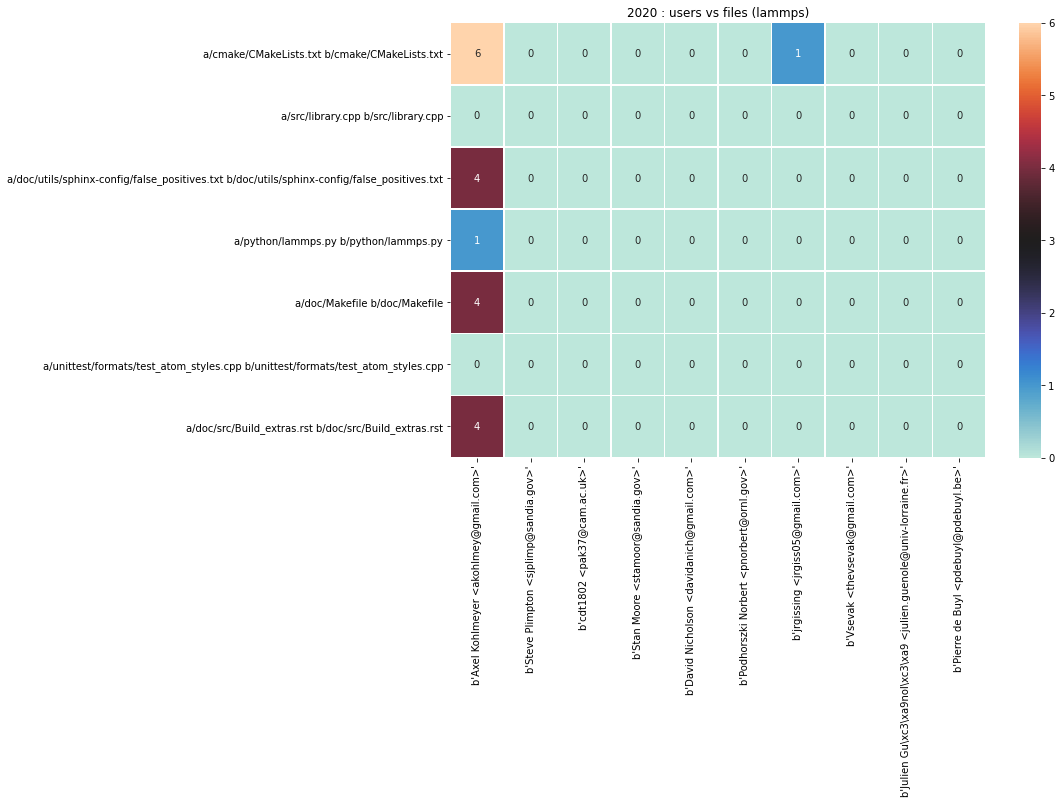

<function __main__.make_map(curr_year)>

In [44]:
def make_map(curr_year): 
  fig, ax = plt.subplots(figsize=(12,8))
  frame_df   = make_pandas_df(year=curr_year, dims=(height,width))
  frame_ret  = sb.heatmap(frame_df, annot=True, linewidths=.5, cmap='icefire')
  plt.title(str(curr_year) + " : users vs files (lammps)") 
  plt.show() 

interact(make_map, curr_year=years)

Consequently, we can get a better idea of just how much of an impact each developer has on the project, by considering which types of files they access, and how often. 

The above applies for a single individual, and can help diagnose months of reduced activity. However, what if a team leader wanted a picture of how well all of their team is performing? In particular, we we want to know by how much each user is contributing to the project. 

One way to answer this question, is to visualize each user's contributions per business quarter, over time, and observe the trends. For example, below we show the trends in contributions of the top 3 users with the most commits:

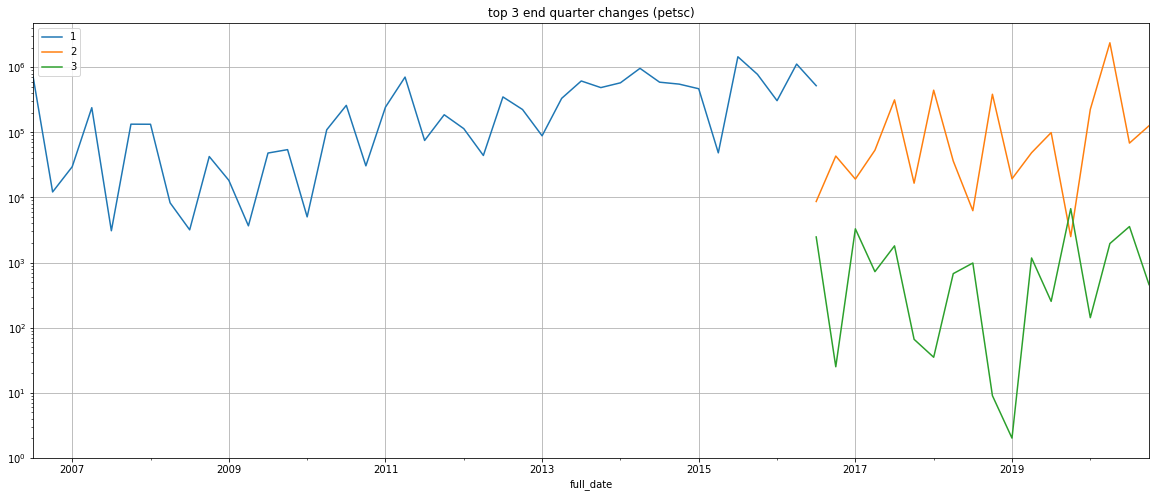

In [45]:
fig, ax = plt.subplots() 
persons = [] 
for i in range(3):
  topi_pd = sorted_people_commits()[i]
  p       = list(topi_pd['person'])[0]
  persons.append(p)
  topi_pd.index = pd.to_datetime(topi_pd['full_date'])
  topi_pd.index = pd.to_datetime(topi_pd.index, utc=True)
  quarter_checkin_i = topi_pd.groupby(pd.Grouper(freq='Q')).sum() 
  quarter_checkin_i['locc'].plot(figsize=(20,8), grid=True, ax=ax, logy=True)
ax.set_title('top 3 end quarter changes (petsc)')
ax.legend(list(map(lambda x : x + 1, list(range(len(persons))))));



---



---



But the file level seems too big for an analysis of this kind. For example, one could increase their contribution by adding nothing but comments into their source script (not to say commenting code isn't good practice)

To remedy this, we want to go lower than file level, and explore changes made to *functions* instead. That is, the goal is to produce a heatmap such as the above, but with functions instead of files on the y-axis.

To do this, we bring in a callgraph for the repository (root as the source directory). Since each node in the graph is a function name, we go through the commit history, and scan the commit's patch for the node (function match). If a match is found, the commit's author's index is incremeted in the function's vector of modifiers (much like we did with files).

We explore this analysis below:

In [ ]:
if google_colab: 
    !pip install networkx pydot graphviz

In [50]:
import networkx as nx

from networkx.drawing.nx_pydot import from_pydot, read_dot

In [52]:
if google_colab:
    !head -20  data_path + '/high_churn_data/callgraph.dot'
    !head -20 data_path + '/high_churn_data/lamps_unmangle.dot'

In [56]:
str_r = ''.join(open(os.path.join(data_path, 'high_churn_data/lamps_unmangle.dot'), 'r').readlines()[2:])

In [57]:
unmangled_f = open(os.path.join(data_path, 'high_churn_data/clean_unmangle.dot'), 'w')
unmangled_f.write(str_r)

4636355

In [58]:
# create dictionary of hashed names to label names 
import re 
split_str = str_r.split(';')
label_lines = [l.strip() for l in split_str[1:] if 'label' in l]
hash_to_actual = {}
count = 0
for line in label_lines: 
  line_l     = line.split(' ')
  node_hash  = line_l[0]
  label_info = line_l[1]
  node_name  = label_info.split(',')[1].split('=')[-1][:-1] if label_info.split(',')[1].split('=')[-1][-1] == ']' else label_info.split(',')[1].split('=')[-1]
  hash_to_actual[node_hash] = node_name

In [60]:
# import this as a nx graph 
G = nx.Graph(read_dot(os.path.join(data_path,'high_churn_data/clean_unmangle.dot')))

Let's look at how many nodes we have in G

In [61]:
from networkx.classes.function import info  
print(info(G))

Name: Call graph
Type: Graph
Number of nodes: 7256
Number of edges: 22650
Average degree:   6.2431


We can attempt a visual of the callgraph

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(24,18))
nx.draw_networkx(G, ax=ax)

What a mess! 

Instead of the whole graph, We can get a sense of what the most important functions are, and how they interact, by looking at the **K-Core** of the callgraph. A K-core is a maximal subgraph that contains nodes of degree k or more. The main core, is the k-core with largest degree k. 

In [64]:
from networkx.algorithms.core import *
G.remove_edges_from(nx.selfloop_edges(G)) # graphs with self loops are not permitted by this operation
G_kcore = k_core(G)

In [65]:
print(info(G_kcore))

Name: Call graph
Type: Graph
Number of nodes: 99
Number of edges: 1192
Average degree:  24.0808


Notice the average node degree increase 4x!

Visualize the K-core

In [66]:
import matplotlib.pyplot as plt

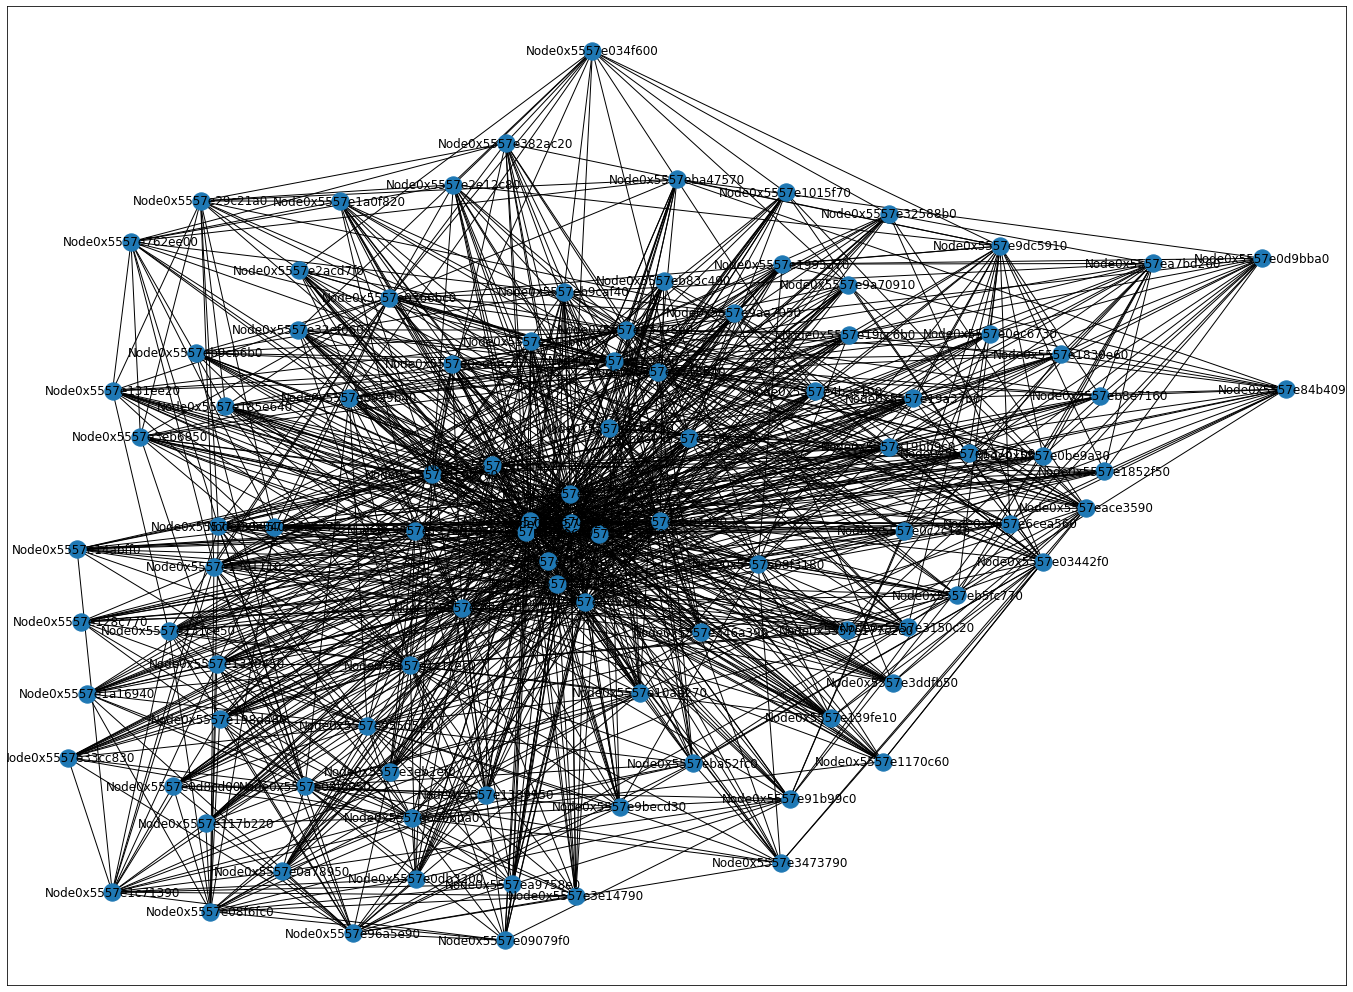

In [74]:
fig, ax = plt.subplots(1,1,figsize=(24,18))
nx.draw_networkx(G_kcore, ax=ax)

Much Cooler! **Note:** would be even cooler if nodes could be dragged and dropped around

**Note: ** we can recover the K in K-core and unhash any of the nodes names if we wanted to:

In [76]:
#k in k-core
d = core_number(G_kcore)

In [77]:
print(d)

{'Node0x5557e1a0f820': 15, 'Node0x5557e696bba0': 15, 'Node0x5557e1389950': 15, 'Node0x5557e5a04d80': 15, 'Node0x5557e9aa7050': 15, 'Node0x5557e131ce50': 15, 'Node0x5557e19cc6b0': 15, 'Node0x5557e0366bc0': 15, 'Node0x5557e03478e0': 15, 'Node0x5557e1995370': 15, 'Node0x5557e4b3c100': 15, 'Node0x5557e955d540': 15, 'Node0x5557ead747e0': 15, 'Node0x5557e127e810': 15, 'Node0x5557e84b4090': 15, 'Node0x5557e3150c20': 15, 'Node0x5557e03442f0': 15, 'Node0x5557eba52fc0': 15, 'Node0x5557eb096dc0': 15, 'Node0x5557e177c2e0': 15, 'Node0x5557e9becd30': 15, 'Node0x5557e08f3180': 15, 'Node0x5557e130c540': 15, 'Node0x5557e19a37b0': 15, 'Node0x5557eacfd7a0': 15, 'Node0x5557e09079f0': 15, 'Node0x5557e346a390': 15, 'Node0x5557e117b220': 15, 'Node0x5557e33cc830': 15, 'Node0x5557e9dc5910': 15, 'Node0x5557e131ee20': 15, 'Node0x5557e1170c60': 15, 'Node0x5557e345bdd0': 15, 'Node0x5557eb9cb6b0': 15, 'Node0x5557eb5fc770': 15, 'Node0x5557ea9758e0': 15, 'Node0x5557e0347550': 15, 'Node0x5557e91b99c0': 15, 'Node0x5557

Thus, we can conclude that the maximal core we obtained is a 15-core. Since our nodes are functions, and an edge between nodes represents a function call, what we have obtained is a maximal subset of our functions in which function call at least 15 other functions. 

In [78]:
# unhash names
d_unhashed = {}
for k, v in d.items():
  if k in hash_to_actual.keys(): 
    d_unhashed[hash_to_actual[k]] = v 
  else:
    continue 
d_unhashed

{'"{LAMMPS_NS::FixTMD::FixTMD(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::Modify::find_fix(std::__cxx11::basic_string\\<char': 15,
 '"{LAMMPS_NS::FixController::FixController(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::Balance::options(int': 15,
 '"{LAMMPS_NS::FixAveHisto::FixAveHisto(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::FixTempRescale::FixTempRescale(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::Error::one(std::__cxx11::basic_string\\<char': 15,
 '"{fmt::v7_lmp::basic_string_view\\<char\\>': 15,
 '"{LAMMPS_NS::FixTempBerendsen::FixTempBerendsen(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::Balance::command(int': 15,
 '"{LAMMPS_NS::Variable::find(char': 15,
 '"{strcmp}"': 15,
 '"{LAMMPS_NS::Fix::~Fix()}"': 15,
 '"{std::__cxx11::basic_string\\<char': 15,
 '"{LAMMPS_NS::ReadRestart::file_search(char*': 15,
 '"{operator': 15,
 '"{LAMMPS_NS::Variable::evaluate(char*': 15,
 '"{strcpy}"': 15,
 '"{LAMMPS_NS::FixNH::FixNH(LAMMPS_NS::LAMMPS*': 15,
 '"{LAMMPS_NS::ComputeChunkAtom::ComputeChunkAtom(LAMMPS_NS::LAM

Below, we associate functions in the callgraph with their developers (by searching for function name in commit patches as mentioned above)

In [79]:
!git clone https://github.com/lammps/lammps.git

Cloning into 'lammps'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 249020 (delta 2), reused 1 (delta 0), pack-reused 249010
Receiving objects: 100% (249020/249020), 504.98 MiB | 27.88 MiB/s, done.
Resolving deltas: 100% (209492/209492), done.
Updating files: 100% (10515/10515), done.


In [80]:
!ls 

Copy_Template_high_churn.ipynb          SpackPatternsTest.ipynb
IssueExtraction.ipynb                   Template_high_churn.ipynb
PETScEmailTracebackCategorization.ipynb data
README.md                               lammps
SpackHighChurn.ipynb


In [81]:
cd lammps/

/Users/norris/research/ideas-uo/sandbox/lammps


In [82]:
#89842fc7c443b48c431aa305d83d7b69319e1bd2' #this is the sha used to generate the callgraph

In [83]:
!git reset --hard 89842fc7c443b48c431aa305d83d7b69319e1bd2

Updating files: 100% (3754/3754), done.
HEAD is now at 89842fc7c Merge pull request #2418 from akohlmey/collected-small-changes


In [84]:
!mkdir temp

In [85]:
!git log -5000 > temp/logShas5000.txt

In [86]:
!head -30 temp/logShas5000.txt

commit 89842fc7c443b48c431aa305d83d7b69319e1bd2
Merge: 28641bcbc 61c33e562
Author: Axel Kohlmeyer <akohlmey@gmail.com>
Date:   Wed Oct 14 17:45:10 2020 -0400

    Merge pull request #2418 from akohlmey/collected-small-changes
    
    Collected small changes and bugfixes for the stable release

commit 28641bcbc7cc4ace6132a17ccc20d0571cac9a4b
Merge: d27c7cd2f 67803fe17
Author: Axel Kohlmeyer <akohlmey@gmail.com>
Date:   Wed Oct 14 17:18:02 2020 -0400

    Merge pull request #2402 from ndtrung81/gpu-dpd
    
    Allowed dpd/tstat/gpu and dpd/gpu to work together in pair style hybrid

commit 61c33e5622b19229964497a2677446c8cbf900e8
Author: Axel Kohlmeyer <akohlmey@gmail.com>
Date:   Wed Oct 14 16:58:08 2020 -0400

    update documentation conventions for recent changes to the manual.

commit 3926cbe5f0dcf55ff41ac943a9fd82753465d6d2
Merge: 865b159d1 45939602a
Author: Axel Kohlmeyer <akohlmey@gmail.com>
Date:   Wed Oct 14 15:18:03 2020 -0400

    Merge branch 'patch-3' of github.com:evoyiat

In [87]:
with open('temp/logShas5000.txt', 'r') as logfile: 
  shas = []
  count = 0
  for line in logfile.readlines(): 
    line_l = line.strip().split() 
    if isinstance(line_l, list):
      if len(line_l) >= 2 and (line_l[0] == 'commit'): 
        shas.append(line_l[1])

Below, one can sign in usign their github password, but that is soon to be deprecated in preference of authorization tokens. Which, once inside one's account, can be generated as shown [here](https://docs.github.com/en/free-pro-team@latest/github/authenticating-to-github/creating-a-personal-access-token)

In [91]:
import requests 
import getpass 
resp_json = None 
OK = 200 
username = input("Username: ") 
password = getpass.getpass(prompt='Auth Token: ', stream=None)
AUTH = (username, password)
commit_objs = [] 
count = 0 
for sha in shas: 
  url = 'https://api.github.com/repos/lammps/lammps/commits/' + sha        
  resp = requests.get(url, auth=AUTH) 
  if resp.status_code != OK:
    print(resp.status_code)
  else:
    commit_objs.append(resp.json())
  count += 1
  if count % 500 == 0: 
    print(url)

Username:  brnorris03
Auth Token:  ··········


403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403


In [ ]:
test_fnames = [e[1:] for e in list(hash_to_actual.values())]
# test_fnames
test_f_not_lammps = [e for e in test_fnames if '{LAMMPS_NS::' not in e] 
test_f_lammps = [e[len('{LAMMPS_NS::'):] for e in test_fnames if '{LAMMPS_NS' in e]

In [ ]:
tests_fnames = test_f_lammps + test_f_not_lammps

Some data clean up

In [ ]:
import copy 
new_test_fnames = []
for name in tests_fnames:
  last_char = name[-1]
  if last_char == "}":
    new_test_fnames.append(name[:-1])
  elif last_char == '"':
    if name[-2] == '}':
      new_test_fnames.append(name[:-2])
    else: 
      new_test_fnames.append(name[:-1])
  else:
    new_test_fnames.append(name)
tests_fnames = copy.deepcopy(new_test_fnames)
tests_fnames = [f.split('(')[0] for f in tests_fnames] # Assume that no two functions of the same `name` in our call graph take arguments of the same type. 

In [ ]:
import re  
def find_func_commiter(f_name, patch_obj, commit_obj):
  func_committer = None 
  for obj in patch_obj: 
    if f_name in obj: 
      func_committer = commit_obj['commit']['committer']['name']
  return func_committer

In [ ]:
black_list = ['int)', '{', '{atof', '{double', '{exp', '{write', '{printf']
functions_dict = {}
max_user_count = 0 
user_count = 0 
users_dict = {} 
for name in tests_fnames: 
  if name in black_list: 
    continue 
  for obj in commit_objs: 
    obj_files   = obj['files'] 
    try:
      obj_patches = [e['patch'] for e in obj_files if e['filename'][-4:] == '.cpp']
    except KeyError:
      continue 
    f_committer = find_func_commiter(name, obj_patches, obj) 
    if isinstance(f_committer, str): 
      if name in functions_dict.keys(): 
        functions_dict[name].append(f_committer) 
      else: 
        functions_dict[name] = [f_committer] 
      if f_committer in users_dict: 
        continue 
      else: 
        users_dict[f_committer] = user_count 
        user_count += 1 

In [ ]:
1 + max(users_dict.values()) == len(users_dict.keys()) 

Thus, using 5000 commits in the past, we can associate 1300 out of 7256 functions in the callgraph with developers. 

Let's see how many functions in our core graph we have annotated: 

In [ ]:
count = 0 
core_funcs = {} 
for n in functions_dict.keys(): 
  for s in d_unhashed: 
    if n in s: 
      core_funcs[n] = functions_dict[n]
      count += 1 
count

This is 2/3 of functions in our core callgraph. 

Now, using **functions_dict** and **users_dict** we should be able to generate an pandas dataframe of functions and users, which we can later use to generate a heatmap. 

In [ ]:
f_vectors = {f : [0 for i in range(len(users_dict.keys()))] for f in functions_dict}

In [ ]:
for fname in functions_dict: 
  fusers        = functions_dict[fname] 
  fusers_counts = {u : fusers.count(u) for u in fusers} 
  for u in fusers_counts.keys(): 
    f_vectors[fname][users_dict[u]] = fusers_counts[u]

In [ ]:
index_col = [0 for i in range(len(users_dict.keys()))]
for i in range(len(users_dict.keys())): 
  for u in users_dict.keys(): 
    if users_dict[u] == i : 
      index_col[i] = u 

In [ ]:
new_col = {'index' : index_col}
f_vectors.update(new_col)

In [ ]:
df = pd.DataFrame.from_dict(f_vectors)

In [ ]:
df = df.set_index('index')

Grab a slice of the first alphabetical functions to plot with the top 10 users

In [ ]:
top_df = df.head(10).loc[:, 'AtomVecSphere::process_args':'AtomVec::size_restart']

In [ ]:
plot(top_df, 'users vs functions (lammps)')

And thus, we have achieved our goal of storing function data, instead of files, in the heatmap. 